## Import Packages

In [1]:
%matplotlib inline
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import matplotlib as mpl
import numpy as np
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

## Load Dataset

In [2]:
ds = xr.open_mfdataset("/Users/abanihi/datasets/ACOM/cam_chem/*.nc").load()
ds

<xarray.Dataset>
Dimensions:       (ilev: 33, lev: 32, nbnd: 2, ncol: 48602, time: 12)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * time          (time) object 2013-02-01 00:00:00 ... 2014-01-01 00:00:00
Dimensions without coordinates: nbnd, ncol
Data variables:
    lat           (time, ncol) float64 -35.26 -35.65 -36.26 ... 36.68 36.05
    lon           (time, ncol) float64 315.0 315.8 317.2 ... 133.7 136.3 135.0
    area          (time, ncol) float64 4.397e-05 0.0001465 ... 0.0003665
    hyam          (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm          (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    hyai          (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.0 0.0
    hybi          (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9636 0.9851 1.0
    date          (time) int32 20130201 20130301 20130401 ... 2013

In [3]:
# Set all invariant variables to be coords.
invariants = [v for v in ds.variables if not {'ncol', 'time'}.issubset(set(ds[v].dims))]
invariants.extend(['lat', 'lon', 'area'])
print(invariants)

['lev', 'ilev', 'hyam', 'hybm', 'hyai', 'hybi', 'time', 'date', 'datesec', 'time_bnds', 'date_written', 'time_written', 'ndbase', 'nsbase', 'nbdate', 'nbsec', 'mdt', 'ndcur', 'nscur', 'co2vmr', 'ch4vmr', 'n2ovmr', 'f11vmr', 'f12vmr', 'sol_tsi', 'nsteph', 'lat', 'lon', 'area']


In [4]:
ds = ds.set_coords(invariants)
ds

<xarray.Dataset>
Dimensions:       (ilev: 33, lev: 32, nbnd: 2, ncol: 48602, time: 12)
Coordinates:
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
    lat           (time, ncol) float64 -35.26 -35.65 -36.26 ... 36.68 36.05
    lon           (time, ncol) float64 315.0 315.8 317.2 ... 133.7 136.3 135.0
    area          (time, ncol) float64 4.397e-05 0.0001465 ... 0.0003665
    hyam          (time, lev) float64 0.003643 0.007595 0.01436 ... 0.001989 0.0
    hybm          (time, lev) float64 0.0 0.0 0.0 0.0 ... 0.9512 0.9743 0.9926
    hyai          (time, ilev) float64 0.002255 0.005032 0.01016 ... 0.0 0.0
    hybi          (time, ilev) float64 0.0 0.0 0.0 0.0 ... 0.9636 0.9851 1.0
  * time          (time) object 2013-02-01 00:00:00 ... 2014-01-01 00:00:00
    date          (time) int32 20130201 20130301 20130401 ... 20131201 20140101
    datesec       (time) int32 0 0 0 0 0 0 0 

In [5]:
lons = np.mod((ds.lon.values[0] + 180), 360) - 180
lats = ds.lat.values[0]
print(lons.shape, lats.shape)

(48602,) (48602,)


In [8]:
def make_map(nrows, ncols, lat, lon, projection=ccrs.PlateCarree()):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(21, 15),
                           subplot_kw=dict(projection=projection), sharex=True, sharey=True)
    for row in range(nrows):
        for col in range(ncols):
            axes[row][col].coastlines(resolution='50m')
            gl = axes[row][col].gridlines(draw_labels=True)
            gl.xlabels_top = gl.ylabels_right = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            axes[row][col].set_aspect('equal')       
    triang = tri.Triangulation(lon, lat)
    return fig, axes, triang

In [9]:
def map_plotter(ds, data_var, nrows, ncols, lats, lons, lev_idx=0):
    sample = ds.isel(lev=lev_idx, time=slice(0, nrows*ncols))[[data_var]]
    fig, axes, triang = make_map(nrows, ncols, lats, lons)
    idxs = nrows * ncols
    for row in range(nrows):
        for col in range(ncols):
            idx = row * ncols + col
            tcp = axes[row][col].tripcolor(triang, sample[data_var].isel(time=idx).values.flatten())
            axes[row][col].set_title(f'time={str(sample.time.values[idx])}')
    cax, kw = mpl.colorbar.make_axes([ax for ax in axes.flat])
    fig.suptitle(f'{sample[data_var].long_name} @ lev={sample.lev.values}\n{sample[data_var].units}', fontsize=20)
    fig.colorbar(tcp, cax=cax, **kw)

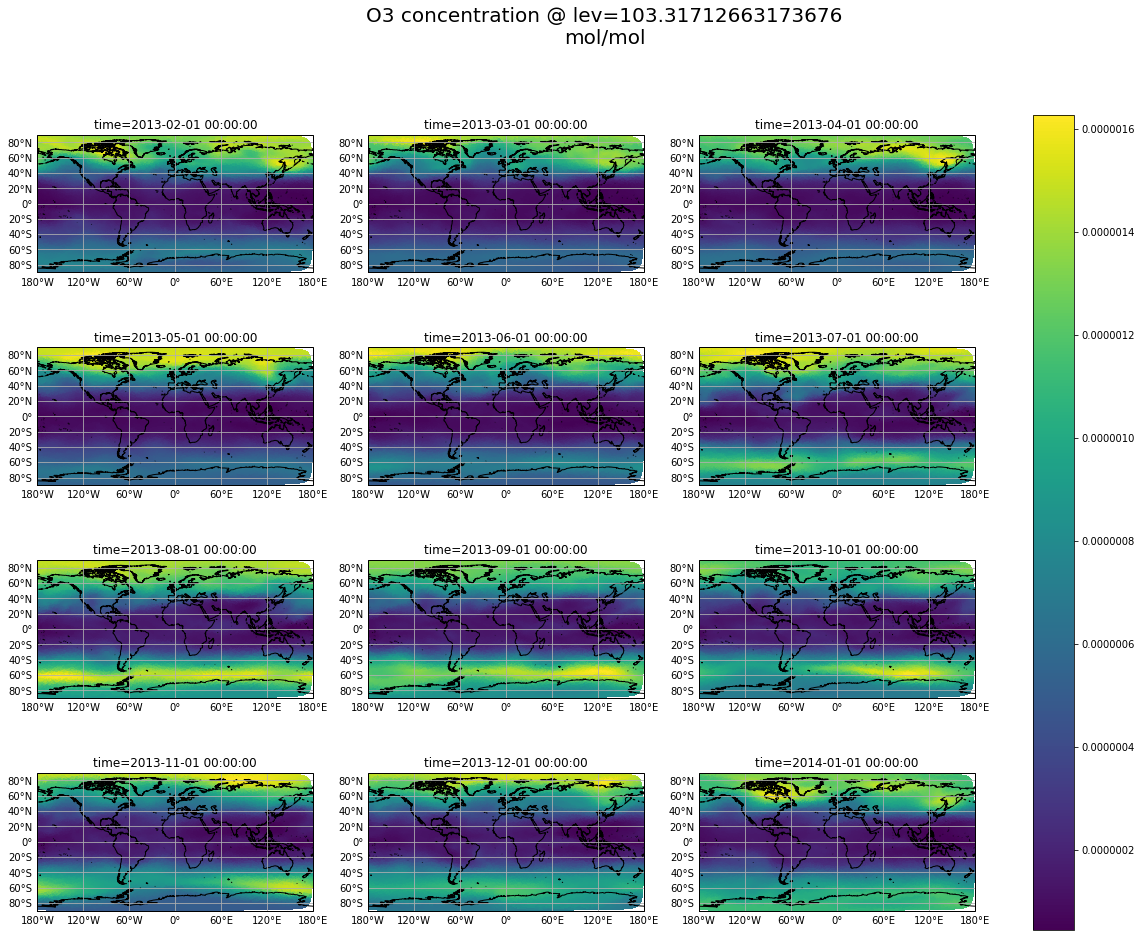

In [10]:
map_plotter(ds, 'O3', 4, 3, lats, lons, lev_idx=10)

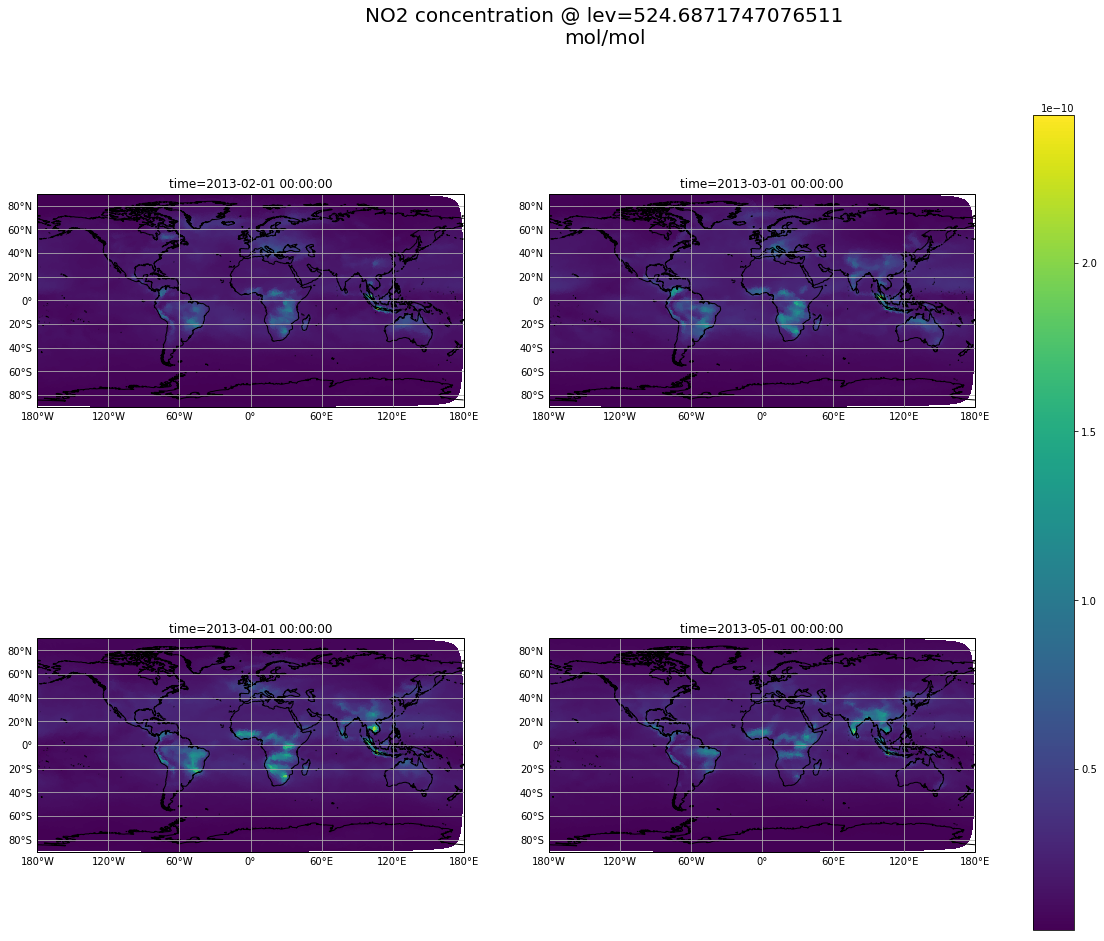

In [11]:
map_plotter(ds, 'NO2', 2, 2, lats, lons, lev_idx=20)

In [12]:
%load_ext watermark
%watermark --iversion -g  -m  -v -u -d

matplotlib 3.0.2
xarray     0.12.1
cartopy    0.17.0
numpy      1.16.1
last updated: 2019-05-07 

CPython 3.6.7
IPython 7.1.1

compiler   : GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)
system     : Darwin
release    : 17.7.0
machine    : x86_64
processor  : i386
CPU cores  : 8
interpreter: 64bit
Git hash   : d67bb6724606d06158b2e6de77933dc4fc13a823
